# Model training and prediction - `s30d`

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir("..")

In [3]:
os.getcwd()

'/Users/ludvigwarnberggerdin/projects/ttris/pemett'

In [4]:
import numpy as np
import pandas as pd

In [5]:
X_train = pd.read_csv("./data/processed/s30d/X_train.csv", index_col = 0)
y_train = pd.read_csv("./data/processed/s30d/y_train.csv", index_col = 0).s30d
X_test = pd.read_csv("./data/processed/s30d/X_test.csv", index_col = 0)
y_test = pd.read_csv("./data/processed/s30d/y_test.csv", index_col = 0).s30d
tc_train = pd.read_csv("./data/processed/s30d/tc_train.csv", index_col = 0).tc
tc_test = pd.read_csv("./data/processed/s30d/tc_test.csv", index_col = 0).tc

In [6]:
y_train.value_counts() / len(y_train.index) * 100

0.0    94.197074
1.0     5.802926
Name: s30d, dtype: float64

In [7]:
cont_features = ["age", "hr", "sbp", "dbp", "spo2", "rr", "delay"]
cat_features = list(X_train.loc[:, ~X_train.columns.isin(cont_features)].columns)

## Run hyper parameter search

In [8]:
import random
from tqdm.notebook import tqdm
from src.models.train_model import generate_all_combinations

In [9]:
import itertools as it
all_breaks = [(0, ) + x + (np.inf,) for x in it.combinations(np.arange(0.01, 1, 0.01), r=3)]

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [11]:
hyper_parameters = {
    "logisticregression__logisticregression__C": [0.1, 0.2],
    "randomforestclassifier__randomforestclassifier__n_estimators": [100, 200],
    "breaks": all_breaks[:1]
}

In [12]:
numerical_pipeline = Pipeline(steps=[
    ("si", SimpleImputer(strategy="median", add_indicator=True)),
    ("ss", StandardScaler())
])
categorical_pipeline = Pipeline(steps=[
    ("si", SimpleImputer(strategy="most_frequent", add_indicator=True)),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])
transformers = [
    ("cont", numerical_pipeline, cont_features), 
    ("cat", categorical_pipeline, cat_features)]
preprocessor = ColumnTransformer(transformers=transformers)

In [13]:
# lgbm = Pipeline(steps=[("lightgbmclassifier", LGBMClassifier())])
lr = Pipeline(steps = [
    ("pp", preprocessor),
    ("logisticregression", LogisticRegression())
])
rf = Pipeline(steps = [
    ("pp", preprocessor),
    ("randomforestclassifier", RandomForestClassifier())
])
base_clfs = [
    # lgbm,
    lr,
    rf
]

In [14]:
all_hyper_parameters = generate_all_combinations(hyper_parameters)

In [15]:
from src.models.classifiers import StackedGeneralizationClassifier

In [16]:
sgclf = StackedGeneralizationClassifier(
    base_clfs=base_clfs, 
    meta_clf=LogisticRegression(),
    use_probas=True, 
    verbose=False
)
sgclf.cv_outer_loop(
    all_hyper_parameters=all_hyper_parameters,
    X=X_train, 
    y=y_train, 
    refit=True
)

  0%|          | 0/4 [00:00<?, ?it/s]

/Users/ludvigwarnberggerdin/miniforge3/envs/pemett/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/ludvigwarnberggerdin/miniforge3/envs/pemett/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

In [17]:
y_test_prob_con, y_test_prob_cut = sgclf.predict(X_test)

In [18]:
from sklearn.metrics import roc_auc_score

In [19]:
auc_test_con = roc_auc_score(y_score = y_test_prob_con, y_true = y_test)
("Hold-out AUC of ROC, continous model: " + 
str(auc_test_con))

'Hold-out AUC of ROC, continous model: 0.9662529853292392'

In [20]:
auc_test_cut = roc_auc_score(y_score = y_test_prob_cut, y_true = y_test)
("Hold-out AUC of ROC, cut model: " + 
str(auc_test_cut))

'Hold-out AUC of ROC, cut model: 0.9194771409075401'

In [21]:
from src.visualization.visualize import (
    plot_roc, 
    plot_precision_recall,
    plot_triage_comparison
)

/Users/ludvigwarnberggerdin/miniforge3/envs/pemett/lib/python3.10/site-packages/plotnine/geoms/geom_rect.py:62: MatplotlibDeprecationWarning: Passing *transOffset* without *offsets* has no effect. This behavior is deprecated since 3.5 and in 3.6, *transOffset* will begin having an effect regardless of *offsets*. In the meantime, if you wish to set *transOffset*, call collection.set_offset_transform(transOffset) explicitly.
/Users/ludvigwarnberggerdin/miniforge3/envs/pemett/lib/python3.10/site-packages/plotnine/geoms/geom_rect.py:62: MatplotlibDeprecationWarning: Passing *transOffset* without *offsets* has no effect. This behavior is deprecated since 3.5 and in 3.6, *transOffset* will begin having an effect regardless of *offsets*. In the meantime, if you wish to set *transOffset*, call collection.set_offset_transform(transOffset) explicitly.
/Users/ludvigwarnberggerdin/miniforge3/envs/pemett/lib/python3.10/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_text : Removed 7 rows

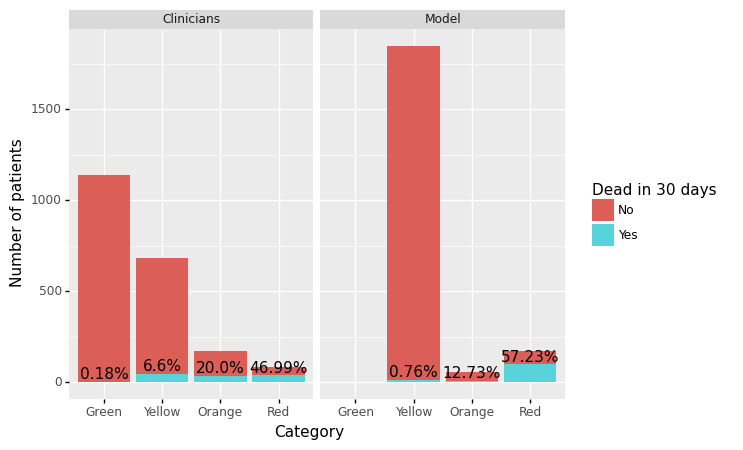

<ggplot: (325353148)>

In [22]:
plot_triage_comparison(y_test, y_test_prob_cut, tc_test)

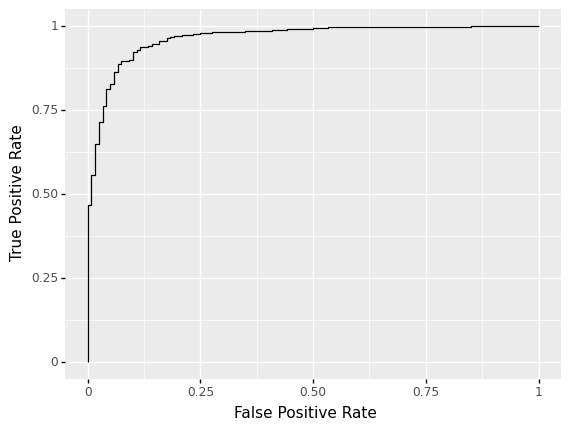

<ggplot: (318972950)>

In [23]:
plot_roc(y_test, y_test_prob_con)

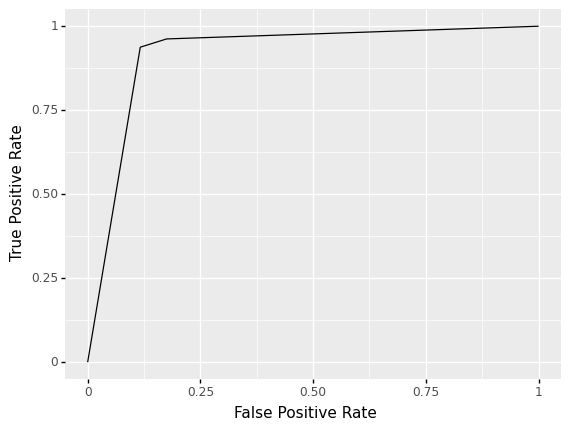

<ggplot: (325517886)>

In [24]:
plot_roc(y_test, y_test_prob_cut)

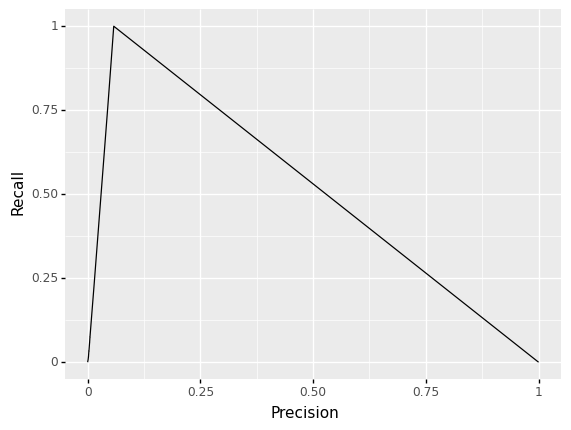

<ggplot: (325528438)>

In [25]:
plot_precision_recall(y_test, y_test_prob_con)

Plot roc curves for each classifier

In [26]:
from src.visualization.visualize import plot_roc_base_clfs

In [27]:
y_test_prob_clfs = sgclf.predict_meta_features(X_test, use_probas = True)
y_test_pred_clfs = sgclf.predict_meta_features(X_test, use_probas = False)

In [28]:
keys = [
    clf.get_params()["steps"][-1][1].__class__.__name__ 
    for clf in sgclf.base_clfs_
]

In [29]:
from sklearn.metrics import (
    precision_score, 
    recall_score, 
    roc_auc_score
)

In [30]:
y_pred_meta_clf = sgclf.predict(X_test, use_probas = False)

In [31]:
y_test_pred_clfs = np.column_stack((y_test_pred_clfs, y_pred_meta_clf))
y_test_prob_clfs = np.column_stack((y_test_prob_clfs, y_test_prob_con))

/Users/ludvigwarnberggerdin/miniforge3/envs/pemett/lib/python3.10/site-packages/plotnine/guides/guide_legend.py:308: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/ludvigwarnberggerdin/miniforge3/envs/pemett/lib/python3.10/site-packages/plotnine/guides/guide_legend.py:308: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


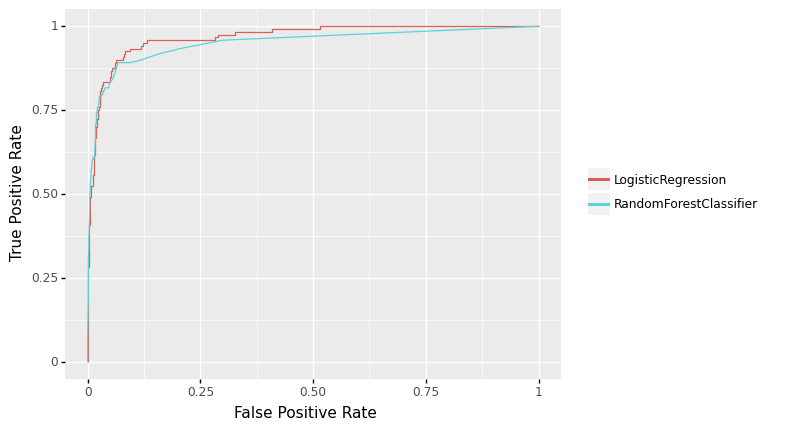

<ggplot: (325489346)>

In [32]:
plot_roc_base_clfs(y_test_prob_clfs, y_test, keys)

In [33]:
from src.models.metrics import bootstrap, compute_performance

During startup - Warning messages:
1: Setting LC_COLLATE failed, using "C" 
2: Setting LC_TIME failed, using "C" 
3: Setting LC_MESSAGES failed, using "C" 
4: Setting LC_MONETARY failed, using "C" 


In [34]:
stats = bootstrap(
    X=X_train,
    y=y_train, 
    tc=tc_train,
    keys=keys + [sgclf.__class__.__name__],
    base_clfs=base_clfs,
    meta_clf=LogisticRegression(),
    all_hyper_parameters=all_hyper_parameters
)

  0%|                                                                          | 0/5 [00:00<?, ?it/s]During startup - Warning messages:
1: Setting LC_COLLATE failed, using "C" 
2: Setting LC_TIME failed, using "C" 
3: Setting LC_MESSAGES failed, using "C" 
4: Setting LC_MONETARY failed, using "C" 
During startup - Warning messages:
1: Setting LC_COLLATE failed, using "C" 
2: Setting LC_TIME failed, using "C" 
3: Setting LC_MESSAGES failed, using "C" 
4: Setting LC_MONETARY failed, using "C" 
/Users/ludvigwarnberggerdin/miniforge3/envs/pemett/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

  0%|          | 0/4 [00:00<?, ?it/s]
                 Estimate
NRI           0.364150339
NRI+          0.355421687
NRI-          0.008728653
Pr(Up|Case)   0.427710843
Pr(Down|Case) 0.072289157
Pr(Down|Ctrl) 0.061100569
Pr(Up|Ctrl)   0.052371917
  0%|          | 0/4 [00:00<?, ?it/s]
                 Estimate
NRI            0.36781609
NRI+           0.41025641
NRI-          -0.04244032
Pr(Up|Case)    0.48717949
Pr(Down|Case)  0.07692308
Pr(Down|Ctrl)  0.05229254
Pr(Up|Ctrl)    0.09473285


R[write to console]: 
NRI estimation:

R[write to console]: Point estimates:

R[write to console]: 
NRI estimation:

R[write to console]: Point estimates:



  0%|          | 0/4 [00:00<?, ?it/s]
                 Estimate
NRI            0.40627400
NRI+           0.47169811
NRI-          -0.06542412
Pr(Up|Case)    0.51572327
Pr(Down|Case)  0.04402516
Pr(Down|Ctrl)  0.05096995
Pr(Up|Ctrl)    0.11639407
  0%|          | 0/4 [00:00<?, ?it/s]
                 Estimate
NRI            0.43096372
NRI+           0.49101796
NRI-          -0.06005424
Pr(Up|Case)    0.51497006
Pr(Down|Case)  0.02395210
Pr(Down|Ctrl)  0.05695467
Pr(Up|Ctrl)    0.11700891
  0%|          | 0/4 [00:00<?, ?it/s]
                 Estimate
NRI            0.40348776
NRI+           0.42384106
NRI-          -0.02035330
Pr(Up|Case)    0.49006623
Pr(Down|Case)  0.06622517
Pr(Down|Ctrl)  0.05913978
Pr(Up|Ctrl)    0.07949309


R[write to console]: 
NRI estimation:

R[write to console]: Point estimates:



In [35]:
# Set bootstrap estimates as data frame
stats_df = pd.concat([pd.DataFrame.from_dict(d, orient="index").stack().to_frame() for d in stats], axis = 1)
stats_df.values.sort()
# Set list for simplifying compiling point estimates
y_test_prob_cuts = [None] * len(keys) + [y_test_prob_cut]
# Set point estimates as data frame
point_estimates = pd.DataFrame.from_dict({
    k: compute_performance(
        y_prob=prob, 
        y_pred=pred, 
        y_true=y_test, 
        y_pred_cut=cut, 
        tc=tc_test
    )
    for prob, pred, cut, k in zip(
        y_test_prob_clfs.T, 
        y_test_pred_clfs.T,
        y_test_prob_cuts,
        keys + [sgclf.__class__.__name__]
    )
}, orient = "index").stack().to_frame()
# Compute quantiles for each metric
d1 = (stats_df - point_estimates).apply(np.quantile, q = 0.1, axis = 1)
d2 = (stats_df - point_estimates).apply(np.quantile, q = 0.9, axis = 1)
# Compute upper bounds and lower bounds
ub = round(point_estimates - d1.to_frame(), 2)
lb = round(point_estimates - d2.to_frame(), 2)
# Compile performamance
perf_df = pd.concat([round(point_estimates, 2), lb, ub, ], axis = 1)

R[write to console]: 
NRI estimation:

R[write to console]: Point estimates:



                 Estimate
NRI           0.562794268
NRI+          0.550000000
NRI-          0.012794268
Pr(Up|Case)   0.558333333
Pr(Down|Case) 0.008333333
Pr(Down|Ctrl) 0.064483112
Pr(Up|Ctrl)   0.051688843


In [36]:
point_estimates

0
LogisticRegression              roc_auc_con          0.967891
                                prec                 0.849846
                                rec                  0.788924
RandomForestClassifier          roc_auc_con          0.950026
                                prec                 0.868328
                                rec                  0.798281
StackedGeneralizationClassifier roc_auc_con          0.966253
                                prec                 0.873272
                                rec                  0.778216
                                roc_auc_cut          0.919477
                                roc_auc_model_model  0.046776
                                roc_auc_model_tc     0.093639
                                nri                  0.562794
                                nri_plus             0.550000
                                nri_minus            0.012794

In [37]:
lb_str = lb.iloc[:, 0].astype(str) 
ub_str = ub.iloc[:, 0].astype(str)
pe_str = round(point_estimates, 2).iloc[:, 0].astype(str)
ci = pe_str + " (" + lb_str + " to " + ub_str +  ")"

In [38]:
perf_df = pd.concat([perf_df, ci.to_frame()], axis = 1)
perf_df.columns = ["point_estimate", "lb", "ub", "ci"]

In [39]:
perf_df

point_estimate    lb  \
LogisticRegression              roc_auc_con                    0.97  0.97   
                                prec                           0.85  0.79   
                                rec                            0.79  0.78   
RandomForestClassifier          roc_auc_con                    0.95  0.95   
                                prec                           0.87  0.82   
                                rec                            0.80  0.78   
StackedGeneralizationClassifier roc_auc_con                    0.97  0.97   
                                prec                           0.87  0.82   
                                rec                            0.78  0.76   
                                roc_auc_cut                    0.92  0.92   
                                roc_auc_model_model            0.05  0.04   
                                roc_auc_model_tc               0.09  0.14   
                                nri                            0.56  0.70   
                                nri_plus                       0.55  0.62   
                                nri_minus                      0.01  0.03   

                                                       ub                   ci  
LogisticRegression              roc_auc_con          0.98  0.97 (0.97 to 0.98)  
                                prec                 0.82  0.85 (0.79 to 0.82)  
                                rec                  0.81  0.79 (0.78 to 0.81)  
RandomForestClassifier          roc_auc_con          0.99  0.95 (0.95 to 0.99)  
                                prec                 0.86  0.87 (0.82 to 0.86)  
                                rec                  0.84   0.8 (0.78 to 0.84)  
StackedGeneralizationClassifier roc_auc_con          0.99  0.97 (0.97 to 0.99)  
                                prec                 0.86  0.87 (0.82 to 0.86)  
                                rec                  0.81  0.78 (0.76 to 0.81)  
                                roc_auc_cut          0.95  0.92 (0.92 to 0.95)  
                                roc_auc_model_model  0.05  0.05 (0.04 to 0.05)  
                                roc_auc_model_tc     0.15  0.09 (0.14 to 0.15)  
                                nri                  0.76   0.56 (0.7 to 0.76)  
                                nri_plus             0.72  0.55 (0.62 to 0.72)  
                                nri_minus            0.09  0.01 (0.03 to 0.09)